# Geometrical Methods in Machine Learning

## Homework 2

### 1. Intrinsic dimension estimation (4 points)

#### Correlation dimension

Given a set $X_n = \{x_1, \dots, x_n\}$ in a metric space, the _correlation dimension_ is defined

$$C_n(r) = \frac{2}{n(n -1)} \sum_{i=1}^n \sum_{j=i+1}^n \mathbf{1}\{\|x_i - x_j\| < r\}.$$

The correlation dimension is then estimated by plotting $\log C_n(r)$ against $log(r)$ and estimating the slope of the linear part of the graph.

You are asked to implement one of the following intrinsic dimension estimation methods:

- correlation dimension, or
- projection angle (Lecture 5 slides, pp. 31-34)

Evaluate the obtained method and compare the estimates with global and local PCA and maximum likelihood estimation method for the airfoils and digits from [seminar 3](https://github.com/oleg-kachan/GMML2022/blob/main/seminar3/seminar3_solution.ipynb) datasets and summarize the obtained results in a table. Conclude.

Feel free to reuse the code from Seminars 1 and 3.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance, distance_matrix
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
import os
from pathlib import Path
import PIL

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import load_digits, fetch_olivetti_faces

In [ ]:
def corr_dim(X, r):
    n = X.shape[0]
    dist_matrix = distance_matrix(X, X)
    return 1 / (n * (n - 1)) * np.sum(dist_matrix < r)

def estimate_corr(X, steps=100, begin=-5, end=1, plot=True):
    rs = np.logspace(begin, end, steps, base=10)
    cds = np.array([corr_dim(X, r) for r in tqdm_notebook(rs)])
    slope = np.diff(np.log10(cds)) / np.diff(np.log10(rs))
    inds = np.where(slope > 1e-1)[0]
    a, b = np.polyfit(np.log10(rs)[inds], np.log10(cds)[inds], 1)
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=90)
        ax.plot(np.log10(rs), np.log10(cds), ".", ms=4)
        x = np.linspace(np.log10(rs)[inds][0], np.log10(rs)[inds][-1], 50)
        y = b + a * x
        ax.plot(x, y)
        ax.set_ylabel("$\log_{10}C_n(r)$")
        ax.set_xlabel("$\log_{10}(r)$")
        ax.set_title("Correlation dimesion")
        ax.set_ylim(np.log10(cds).min() - 0.1, np.log10(cds).max() + 0.1)
        ax.set_xlim(begin - 0.1, end + 0.1)
        ax.grid(linestyle="dotted")
        plt.show()
    return a

In [ ]:
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in tqdm_notebook(iters):
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

Airfols

In [ ]:
data_airfoils = pd.read_csv('airfoils.csv', header=None).values

  0%|          | 0/100 [00:00<?, ?it/s]

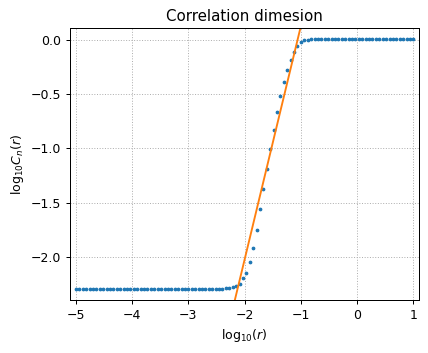

2


In [ ]:
dim_c_airfoils = int(estimate_corr(data_airfoils))
print(dim_c_airfoils)

  0%|          | 0/20 [00:00<?, ?it/s]

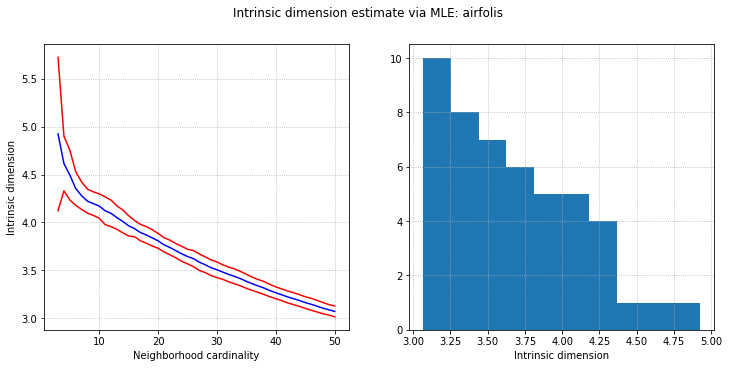

3


In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 20

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_airfoils, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE: airfolis")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()
dim_mle_airfoils = int(intdim_k_repeated.mean())
print(dim_mle_airfoils)

MNIST

In [ ]:
data_mnist = load_digits().data

  0%|          | 0/20 [00:00<?, ?it/s]

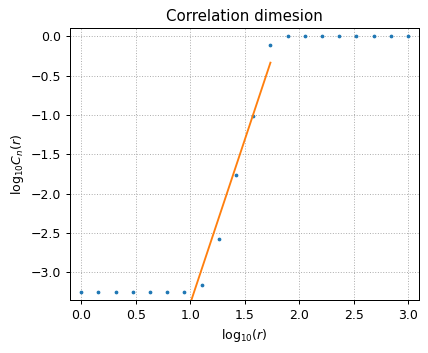

4


In [ ]:
dim_c_mnist = int(estimate_corr(data_mnist, 20, 0, 3))
print(dim_c_mnist)

  0%|          | 0/5 [00:00<?, ?it/s]

6


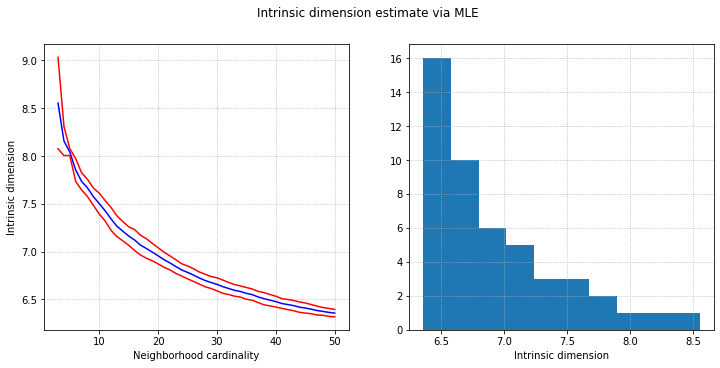

In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_mnist, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
dim_mle_mnist = int(intdim_k_repeated.mean())
print(dim_mle_mnist)
plt.show()

In [ ]:
from tabulate import tabulate
from IPython.core.display import display, HTML, clear_output

table = [
    ["dataset", "Corr dim", "MLE dim"],
    ["airfoils", dim_c_airfoils, dim_mle_airfoils],
    ["MNIST", dim_c_mnist, dim_mle_mnist]
]

display(HTML(tabulate(table, tablefmt="html")))

dataset,Corr dim,MLE dim
airfoils,2,3
MNIST,4,6


### 2. Manifold learning (4 points)

Obtain `Extended Yale B` face dataset ([download](http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip)) which is comprised of 100x100 pixels images of 38 persons times 64 illumination conditions. Resize images to 32x32 pixels. You can do it using `Pillow` ([link](https://pillow.readthedocs.io/), tested) or any other image processing library of your choice.

Estimate the intrinsic dimensionality with a method of your choice and perform dimensionality reduction to entrinsic dimension $\hat{d}$ and dimensions 2 or 3 for visualization purposes using manifold learning methods of your choice.

Compute NPR (neigborhood preservation ratio, see [seminar 4](https://github.com/oleg-kachan/GMML2022/blob/main/seminar4/seminar4_solution.ipynb)) of algorithms you have used for 2 different values of $d = \{2$ or $3, \hat{d} \}$ and fixed number of nearest neighbors $k$. 

Explore the embedding space of size 2 or 3 for clusters and meaningful interpretations, comment the possible meaning of the new coordinates.

Alternatively, you can perform this task on sklearn's `Olivetti faces` dataset.

In [ ]:
!wget -nc http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip -O CroppedYale.zip
!unzip CroppedYale.zip

--2022-05-30 21:05:06--  http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58493820 (56M) [application/zip]
Saving to: ‘CroppedYale.zip’

CroppedYale.zip     100%[===================>]  55.78M   281KB/s    in 3m 24s  

2022-05-30 21:08:30 (280 KB/s) - ‘CroppedYale.zip’ saved [58493820/58493820]

Archive:  CroppedYale.zip
   creating: CroppedYale/yaleB39/
  inflating: CroppedYale/yaleB39/WS_FTP.LOG  
  inflating: CroppedYale/yaleB39/yaleB39_P00.info  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E+00.pgm  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E+20.pgm  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E+45.pgm  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E+90.pgm  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E-20.pgm  
  inflating: CroppedYale/yaleB39/ya

In [ ]:
imgs = list()
ids = list()
# imgs = dict()
for dir_path in sorted(os.listdir("CroppedYale")):
    imgs_dir = []
    for subdir_path in sorted(os.listdir(os.path.join("CroppedYale", dir_path))):
        file_path = Path(os.path.join("CroppedYale", dir_path, subdir_path))
        if file_path.suffix == ".pgm":
            image = np.array(PIL.Image.open(file_path).resize((32,32)))
            imgs_dir.append(image)
            ids.append(int(dir_path[5:]))
    # imgs[dir_path[5:]] = imgs_dir
    imgs.extend(imgs_dir)
imgs = np.stack(imgs, axis=0).reshape(-1, 32*32)

  0%|          | 0/5 [00:00<?, ?it/s]

8.236421274722643


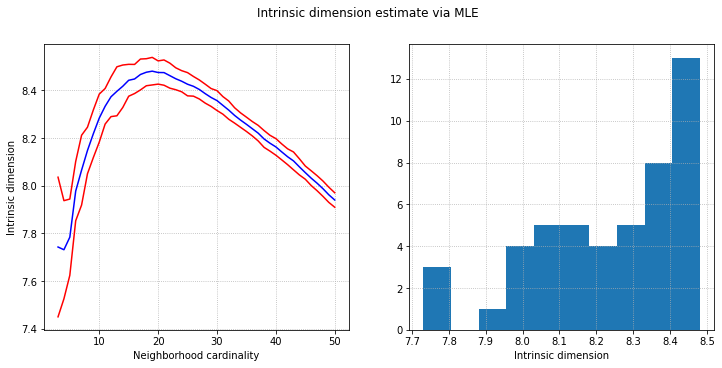

In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             imgs, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
dim_mle_faces = intdim_k_repeated.mean()
print(dim_mle_faces)
plt.show()

In [ ]:
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import KernelPCA

dim = int(8.271078219786713)

In [ ]:
model = SpectralEmbedding

model1 = model(n_components=dim, n_neighbors=30, random_state=42)
X1 = model1.fit_transform(imgs)

model2 = model(n_components=2, n_neighbors=30, random_state=42)
X2 = model2.fit_transform(imgs)

model3 = model(n_components=3, n_neighbors=30, random_state=42)
X3 = model3.fit_transform(imgs)

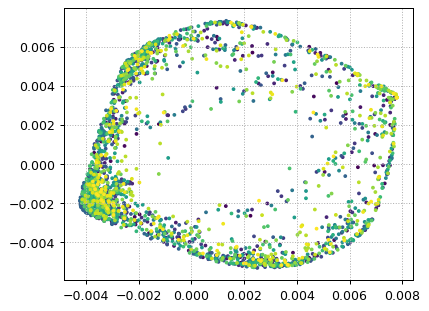

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=90)
ax.scatter(*X2.T, c=ids, s=4)
ax.grid(ls="dotted")
plt.show()

In [ ]:
def NPR(X, Z, k=21):
    
    _, neighborhood_X = NearestNeighbors(n_neighbors=k).fit(X).kneighbors(X)
    _, neighborhood_Z = NearestNeighbors(n_neighbors=k).fit(Z).kneighbors(Z)
    
    n = X.shape[0]
    npr = 0
    for i in range(n):
        npr += np.intersect1d(neighborhood_X[i], neighborhood_Z[i]).shape[0]
    
    return npr / (k * n)

npr1 = NPR(imgs, X1)
npr2 = NPR(imgs, X2)
npr3 = NPR(imgs, X3)

In [ ]:
print(f"intrinsic dim: {npr1:.2f}\ndim=2: {npr2:.2f}\ndim=3: {npr3:.2f}")

intrinsic dim: 0.40
dim=2: 0.30
dim=3: 0.31


Neighborhood preserving ratio for estimated intrinsic dimension is the highest.

#### Grading:

- 8/10 points are awarded for completing all the tasks and giving proper answers to questions.
- 2/10 points are awarded for the quality of reporting, be sure to give explanations and comments to your solutions.
- +1 extra point may be awarded for the extra work performed, be creative.